# Amortized Inference for a NLME Model

## Simulation & Training Phase

In [1]:
gpu_id = 0

model_name = ['fröhlich-simple', 'fröhlich-detailed', 'fröhlich-sde',
              'pharmacokinetic_model', 'clairon_small_model'][0]
if model_name == 'fröhlich-detailed' or model_name == 'pharmacokinetic_model' or 'clairon' in model_name:
    from juliacall import Main as jl  # needed for cluster to load julia

# specify which model to use
network_idx = 16
load_best_network = False

# load necessary packages
import numpy as np
import pandas as pd

# for plots
import matplotlib.pyplot as plt
from tqdm import tqdm

# minor stuff
from datetime import datetime
from time import perf_counter

load BayesFlow package (https://bayesflow.readthedocs.io/)

In [2]:
from bayesflow.simulation import GenerativeModel
from bayesflow import diagnostics

/Users/jonas.arruda/miniconda/envs/amortizedNLME/lib/python3.10/site-packages/bayesflow/trainers.py:27: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
# example training
max_epochs = 1
iterations_per_epoch = 10

# show or save plots
show_plots = True
save_plots = False
    
# training params
early_stopping = True
presimulate = False
train_network = False
batch_size = 128
max_to_keep = 3  # standard 3, if all should be saved: set to max_epochs

## Load model


In [4]:
presimulation_path = 'data/'

if model_name == 'fröhlich-simple':
    from models.froehlich_model_simple import FroehlichModelSimple
    model = FroehlichModelSimple(network_idx=network_idx, load_best=load_best_network)
    
    use_presimulation = False
elif model_name == 'fröhlich-detailed':
    from models.froehlich_model_detailed import FroehlichModelDetailed
    model = FroehlichModelDetailed(network_idx=network_idx, load_best=load_best_network)

    use_presimulation = True
    presimulation_path += 'presimulations_froehlich_detailed'

elif model_name == 'fröhlich-sde':
    from models.froehlich_model_sde import FroehlichModelSDE
    model = FroehlichModelSDE(network_idx=network_idx, load_best=load_best_network)

    use_presimulation = True
    presimulation_path += 'presimulations_froehlich_sde'
    
elif model_name == 'pharmacokinetic_model':
    from models.pharmacokinetic_model import PharmacokineticModel
    model = PharmacokineticModel(network_idx=network_idx, load_best=load_best_network)
    
    use_presimulation = True
    presimulation_path += 'presimulations_pharma'
    
elif model_name == 'clairon_small_model':
    from models.clairon_small_model import ClaironSmallModel
    model = ClaironSmallModel(network_idx=network_idx, load_best=load_best_network)

    use_presimulation = True
    presimulation_path += 'presimulations_small_clairon'
else:
    raise NotImplementedError('model not implemented')

using a TimeSeriesTransformer with a  LSTM template and output dimension 12 as summary network
using a 6-layer cINN as inference network with 2 layers of design affine
prior mean: [-3.  -3.   5.   0.   0.  -0.1]
prior covariance diagonal: [ 5.  5. 11.  2.  6.  2.]
Using the model SimpleFroehlichModel


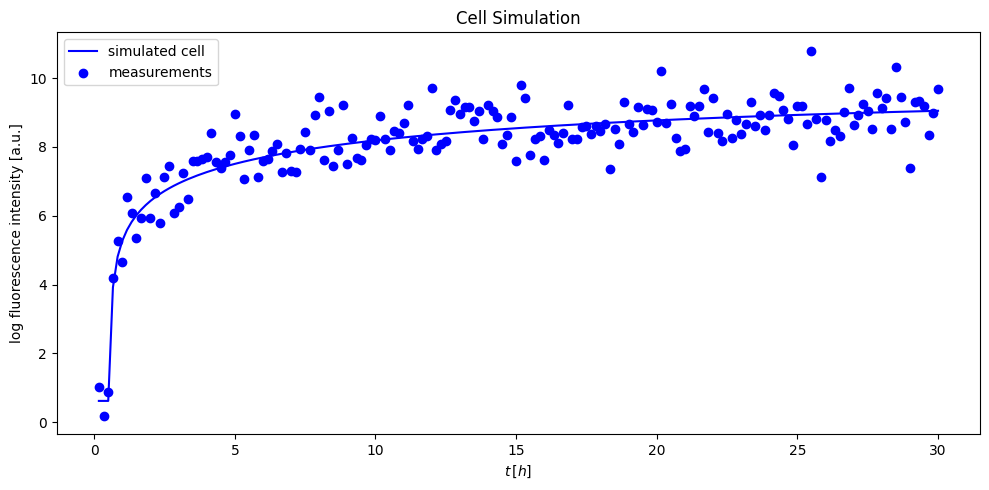

In [5]:
if show_plots:
    model.plot_example()

In [7]:
if presimulate:
    # sleep(int(job_array_id) % 200)  # so batch file does not get overwritten

    generative_model = GenerativeModel(model.prior, model.simulator)
    start_time = perf_counter()
    np.random.seed(42)
    generative_model.presimulate_and_save(batch_size, 
                                          folder_path=presimulation_path,
                                          iterations_per_epoch=iterations_per_epoch,
                                          epochs=max_epochs,
                                          disable_user_input=True)
                                          # extend_from=int(job_array_id)*max_epochs)
    end_time = perf_counter()
    print(f'simulation time: {(end_time-start_time)/60} minutes')

## Training

In [ ]:
trainer = model.build_trainer('networks/' + model.network_name)
print(model.network_name)

each epoch a number of iterations each with batch_size many simulations is performed

In [ ]:
history = {}
if train_network and not use_presimulation:
    # simulation is done whenever needed
    start_time = perf_counter()
    history = trainer.train_online(epochs=max_epochs,
                                  iterations_per_epoch=iterations_per_epoch,
                                  batch_size=batch_size,
                                  early_stopping=early_stopping,
                                  validation_sims=iterations_per_epoch)
    end_time = perf_counter()
    print(f'training time: {(end_time-start_time)/60} minutes')

In [ ]:
if train_network and use_presimulation:
    trainer._setup_optimizer(optimizer=None,
                             epochs=max_epochs,
                             iterations_per_epoch=iterations_per_epoch)

In [ ]:
if train_network and use_presimulation:
    # simulation done before
    start_time = perf_counter()
    history = trainer.train_from_presimulation(presimulation_path=presimulation_path,
                                               optimizer=trainer.optimizer,
                                               max_epochs=max_epochs,
                                               early_stopping=early_stopping,
                                               validation_sims=iterations_per_epoch)

    end_time = perf_counter()
    print(f'training time: {(end_time-start_time)/60} minutes')

In [ ]:
# load or save losses
if train_network:
    history['train_losses'].to_csv(f"output/losses/{model.network_name}_train_losses.csv")
    history['val_losses'].to_csv(f"output/losses/{model.network_name}_val_losses.csv")
else:
    train_losses = pd.read_csv(f"output/losses/{model.network_name}_train_losses.csv", index_col=0)
    val_losses = pd.read_csv(f"output/losses/{model.network_name}_val_losses.csv", index_col=0)
    history = {'train_losses': train_losses,
              'val_losses': val_losses}

In [ ]:
fig_losses = diagnostics.plot_losses(history['train_losses'], val_losses=history['val_losses'],
                                     moving_average=True)
if save_plots:
    fig_losses.savefig(f'plots/calibration/{model.network_name}_fig_losses.png')

In [ ]:
# load data, simulate posterior and plot
test_data = model.load_data(n_data=25)  # or load synthetic data with synthetic=True
data_posterior_draws = model.draw_posterior_samples(data=test_data, n_samples=100)

In [ ]:
rows = 5
fig, ax = plt.subplots(rows, int(np.ceil(len(test_data) / rows)), tight_layout=True, figsize=(10, rows*3))
axis = ax.flatten()
    
for p_id in tqdm(range(len(test_data))):
    axis[p_id] = model.prepare_plotting(test_data[p_id], data_posterior_draws[p_id], axis[p_id])
    _, labels = axis[p_id].get_legend_handles_labels()

fig.legend(labels, ncol=3, loc='upper center', bbox_to_anchor=(0.5, 1))
if save_plots:
    fig.savefig(f'plots/calibration/{model.network_name}_fit.png')
plt.show()

## Get Posterior Parameter Samples and Plot Them Against True Values

If the training is very short, one should see only uniformly distributed estimates.

**quick and dirty validation:**


If the model can generate data that is quite uninformative, the true posterior means may differ significantly from the ground truth parameter

In [ ]:
new_sims = model.generate_simulations_from_prior(trainer=trainer, n_samples=2500)

In [ ]:
posterior_draws = model.draw_posterior_samples(data=new_sims['summary_conditions'], n_samples=100)

In [ ]:
fig_sbc = diagnostics.plot_sbc_histograms(post_samples=posterior_draws,
                                          prior_samples=new_sims['parameters'],
                                          param_names=model.log_param_names)

for _ax in fig_sbc.axes[model.n_params:]:
    _ax.remove()
if save_plots:
    fig_sbc.savefig(f'plots/calibration/{model.network_name}_fig_sbc.png')

In [ ]:
fig_ecdf_diff = diagnostics.plot_sbc_ecdf(post_samples=posterior_draws,
                                          prior_samples=new_sims['parameters'],
                                          difference=True,
                                          stacked=False,
                                          param_names=model.log_param_names)

if save_plots:
    fig_ecdf_diff.savefig(f'plots/calibration/{model.network_name}_fig_ecdf_diff.png')

In [ ]:
fig_posterior = diagnostics.plot_posterior_2d(posterior_draws=posterior_draws[0],
                                              prior=model.prior,
                                              param_names=model.log_param_names)

if save_plots:
    fig_posterior.savefig(f'plots/calibration/{model.network_name}_fig_posterior.png')

## Get SBC Plots for Different Epochs

In [ ]:
ckpt_list = []# [1, 10, 100, 200, 300, 400, 500]

In [ ]:
for ckpt in ckpt_list:
    print('Load checkpoint', ckpt)
    # restore checkpoint
    trainer.checkpoint.restore('networks/' + model.network_name + f'/ckpt-{ckpt}')
    # sample posterior
    posterior_draws = model.draw_posterior_samples(data=new_sims['summary_conditions'], n_samples=250)

    # make sbc plots
    fig_ecdf_diff = diagnostics.plot_sbc_ecdf(post_samples=posterior_draws,
                                              prior_samples=new_sims['parameters'],
                                              difference=True,
                                              stacked=False,
                                              param_names=model.log_param_names)
    if save_plots:
        fig_ecdf_diff.savefig(f'plots/calibration/epochs_compare/{model.network_name}_fig_ecdf_diff_{ckpt}_.png')
    plt.show()